In [11]:
import numpy as np
import pandas as pd

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_signals(df, title = "Signal Plot with Seaborn"):
    """
    Funkcija za prikaz signalov iz DataFrame-a z uporabo Seaborn.

    Args:
        df (pandas.DataFrame): DataFrame, ki vsebuje časovni stolpec ('time') in signale.
    """
    # Preoblikuj DataFrame v dolgo obliko za Seaborn
    df_melted = df.melt(id_vars="time", var_name="Signal", value_name="Value")
    
    # Ustvari graf z uporabo Seaborn
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_melted, x="time", y="Value", hue="Signal", palette="tab10")
    
    # Nastavitve grafa
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Signal Value')
    plt.grid(True)
    plt.legend(title='Signals')
    plt.show()

# Klic funkcije za prikaz signalov
#plot_signals(generiraniSignali)

In [13]:
from scipy.stats import skewnorm

def generate_rand_signals(time, mu, std, N, distribution="normal", correlation=None, skewness=None):
    """
    Funkcija generira naključne podatke za N signalov glede na podane parametre.

    Args:
        time (numpy array): Časovni intervali (npr. np.arange(0, 20, 0.02)).
        mu (float): Povprečje za generiranje naključnih vrednosti.
        std (float): Standardni odklon za generiranje naključnih vrednosti.
        N (int): Število signalov.
        distribution (str): Type of distribution ('normal', 'uniform', 'exponential').
        correlation (np.ndarray): Correlation matrix for individuals' pupil sizes.

    Returns:
        pandas.DataFrame: DataFrame s časovnimi intervali in generiranimi signali.
    """

    if distribution == "normal":
        if correlation is None:
            if skewness is not None:
                # Prilagodi loc in scale za želeno mu in std s skewnorm
                a = skewness
                mu_skew = skewnorm(a).mean()
                var_skew = skewnorm(a).var()
                scale = std / np.sqrt(var_skew)
                loc = mu - mu_skew * scale
                data = skewnorm.rvs(a, loc=loc, scale=scale, size=(len(time), N))
            else:
                data = np.random.normal(mu, std, size=(len(time), N))        
        else:
            cov_matrix = correlation * std**2
            data = np.random.multivariate_normal([mu] * N, cov_matrix, len(time))
    elif distribution == "uniform":
        data = np.random.uniform(mu - std, mu + std, size=(len(time), N))
    elif distribution == "exponential":
        data = np.random.exponential(scale=std, size=(len(time), N)) + mu
    else:
        raise ValueError("Unsupported distribution type. Choose 'normal', 'uniform', or 'exponential'.")
    
    # Pretvori v DataFrame in dodaj časovni stolpec
    randomSignal_df = pd.DataFrame(data, columns=[f"signal_{i+1}" for i in range(N)])
    randomSignal_df.insert(0, "time", time)  # Dodaj stolpec 'time' na prvo mesto
    



    #sklearn knjižnica
    #scipy signal preveri ac, 
    return randomSignal_df

In [14]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def generate_rand_signals_datetime(duration: float, sampling_rate: float, 
                                  mu: float, std: float, N: int, 
                                  distribution: str = "normal", correlation: np.ndarray = None, start_time: datetime = datetime(2025, 3, 13, 13, 34)) -> pd.DataFrame:
    """
    Generira naključne signale z datetime časovno osjo.

    Args:
        start_time (datetime): Začetni čas meritev (npr. datetime(2025, 3, 13, 13, 34))
        duration (float): Trajanje meritev v sekundah
        sampling_rate (float): Frekvenca vzorčenja v Hz
        mu (float): Povprečna vrednost signala
        std (float): Standardni odklon
        N (int): Število signalov
        distribution (str): Vrsta porazdelitve ('normal', 'uniform', 'exponential')
        correlation (np.ndarray): Korelacijska matrika

    Returns:
        pd.DataFrame: DataFrame z datetime indeksom in signali
    """
    
    # Generiranje časovne osi
    num_samples = int(duration * sampling_rate)
    time_deltas = np.arange(0, duration, 1/sampling_rate)
    datetime_index = pd.to_datetime([start_time + timedelta(seconds=float(t)) for t in time_deltas])
    
    # Generiranje podatkov
    if distribution == "normal":
        if correlation is None:
            data = np.random.normal(mu, std, size=(num_samples, N))
        else:
            cov_matrix = correlation * std**2
            data = np.random.multivariate_normal([mu]*N, cov_matrix, num_samples)
    elif distribution == "uniform":
        data = np.random.uniform(mu - std, mu + std, size=(num_samples, N))
    elif distribution == "exponential":
        data = np.random.exponential(scale=std, size=(num_samples, N)) + mu
    else:
        raise ValueError("Nepodprta vrsta porazdelitve. Izberite 'normal', 'uniform' ali 'exponential'.")

    # Ustvarjanje DataFrame z datetime indeksom
    df = pd.DataFrame(
        data=data,
        columns=[f"signal_{i+1}" for i in range(N)]
    )
    
    # Dodajanje časovnega stolpca
    df.insert(0, 'time', datetime_index)

    # Dodajanje milisekundne natančnosti direktno v stolpec
    df['time'] = pd.to_datetime(df['time']) + pd.to_timedelta(
        np.random.uniform(0, 1/sampling_rate, len(df)), 
        unit='s'
    )
    
    return df


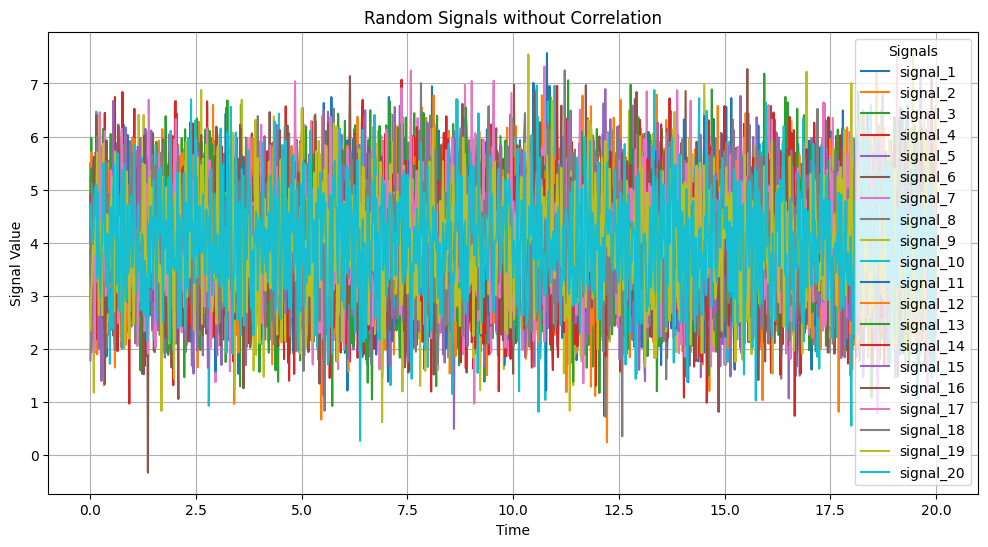

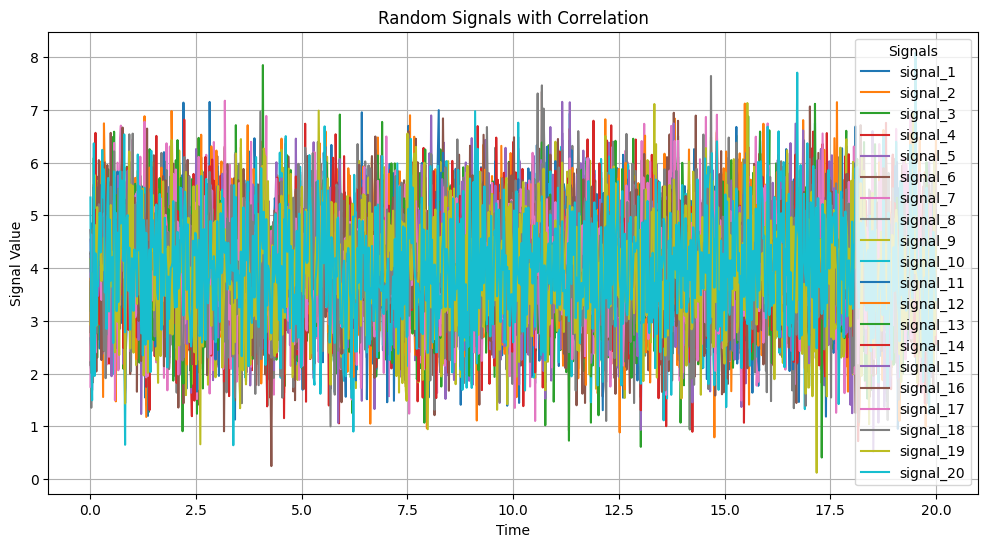

In [15]:
# Primer uporabe:
time = np.arange(0, 20.02, 0.02)  # Časovni intervali od 0 do 20 s korakom 0.02
mu = 4                            # Povprečje
std = 1                           # Standardni odklon
N = 20                            # Število signalov

# Generiraj podatke
random_signals = generate_rand_signals(time=time, mu=mu, std=std, N=N)
plot_signals(random_signals, title="Random Signals without Correlation")

correlation_matrix = np.eye(N) * 0.8 + 0.2  # Korelacijska matrika z delno korelacijo med posamezniki
signals_with_corr = generate_rand_signals(time=time, mu=mu, std=std, N=N, correlation=correlation_matrix)
plot_signals(signals_with_corr, title="Random Signals with Correlation")

# correlation_matrix = np.eye(N) * 0.95 + 0.5  # Korelacijska matrika z delno korelacijo med posamezniki
# signals_with_corr_strong = generate_rand_signals(time=time, mu=mu, std=std, N=N, correlation=correlation_matrix)
# plot_signals(signals_with_corr_strong, title="Random Signals with Strong Correlation")

# correlation_matrix = np.eye(N) * 0.5 + 0.1  # Korelacijska matrika z delno korelacijo med posamezniki
# signals_with_corr_weak = generate_rand_signals(time=time, mu=mu, std=std, N=N, correlation=correlation_matrix)
# plot_signals(signals_with_corr_weak, title="Random Signals with Weak Correlation")

In [16]:
import pandas as pd
from scipy.stats import skew

def statistika(df):
    # 1. Izločite časovni stolpec
    numeric_df = df.drop(columns=['time'])

    # 2. Izračunajte globalne statistike
    povprečje = numeric_df.mean().mean()
    standardni_odklon = numeric_df.stack().std()
    poševnost = skew(numeric_df.stack())

    print(f"Povprečje vseh meritev: {povprečje:.4f}")
    print(f"Standardni odklon: {standardni_odklon:.4f}")
    print(f"Poševnost: {poševnost:.4f}\n")

c:\Users\Leon\OneDrive - Univerza v Ljubljani\Documents\Fe\MAGISTRSKA\koda\.venv\Lib\site-packages\sdv\single_table\base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\Users\Leon\OneDrive - Univerza v Ljubljani\Documents\Fe\MAGISTRSKA\koda\.venv\Lib\site-packages\sdv\single_table\base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


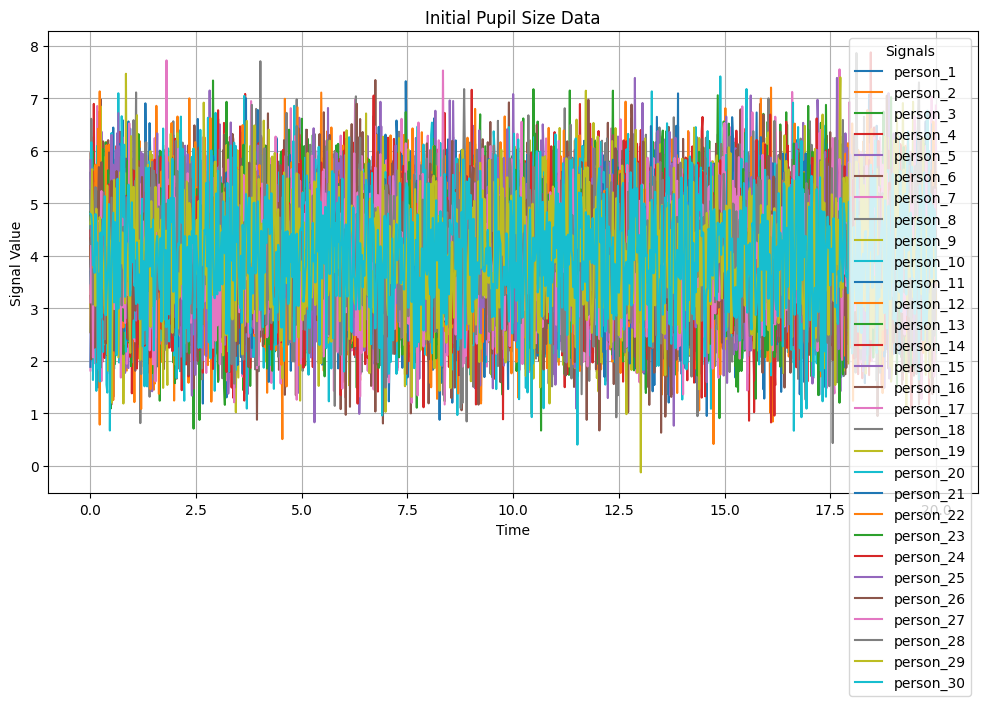

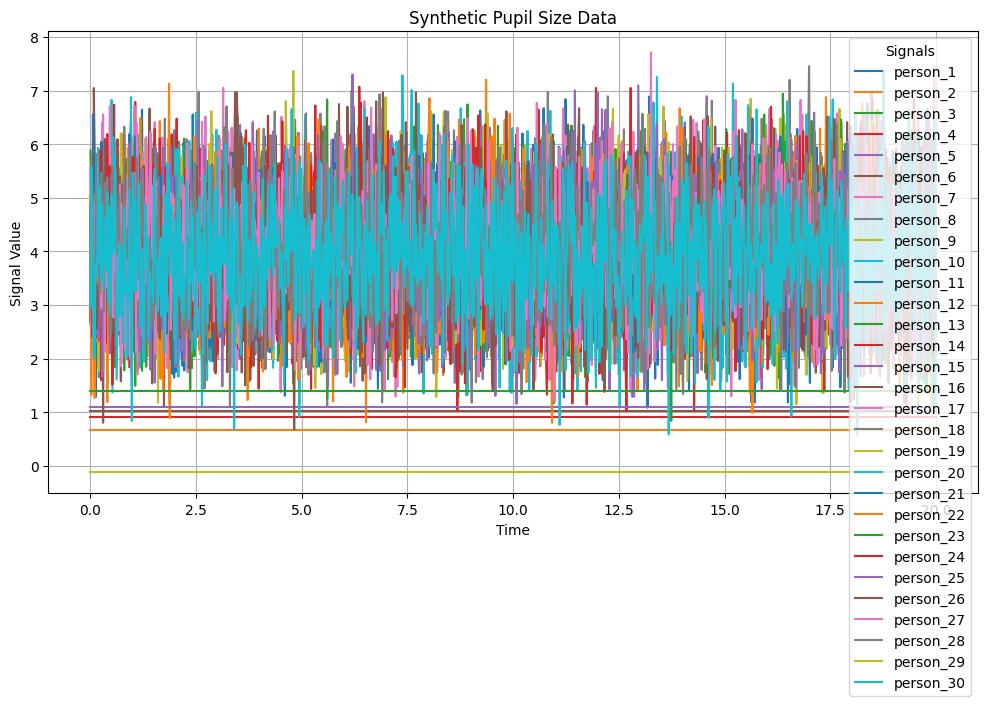

       time  person_1  person_2  person_3  person_4  person_5  person_6  \
0      0.00  3.157098  0.672001  5.880956  0.902023  4.457157   1.01797   
1      0.02  4.416989  0.672001  5.024571  0.902023  3.866519   1.01797   
2      0.04  5.773068  0.672001  4.760181  0.902023  2.549187   1.01797   
3      0.06  3.753108  0.672001  4.513852  0.902023  2.678023   1.01797   
4      0.08  3.206977  0.672001  4.263886  0.902023  2.521089   1.01797   
...     ...       ...       ...       ...       ...       ...       ...   
996   19.92  3.270760  0.672001  4.117425  0.902023  3.967858   1.01797   
997   19.94  4.297162  0.672001  3.464716  0.902023  4.135838   1.01797   
998   19.96  2.412927  0.672001  1.859523  0.902023  3.596003   1.01797   
999   19.98  3.963109  0.672001  3.457588  0.902023  3.404109   1.01797   
1000  20.00  3.076502  0.672001  4.240189  0.902023  5.690107   1.01797   

      person_7  person_8  person_9  ...  person_21  person_22  person_23  \
0     3.473185  4.40120

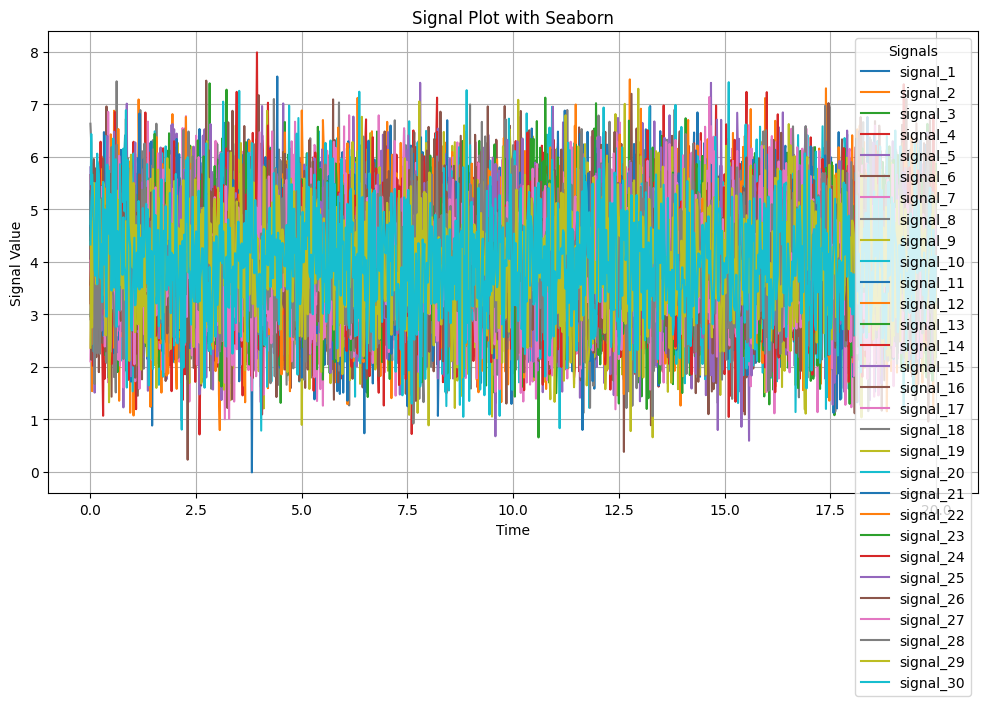

(1001, 31)
(1001, 31)
(1001, 31)


In [17]:
# Generiranje podatkov s pomočjo SDV knjižnice, ki potrebuje metapodatke oz. realne podatke an katerih se "nauči" lastnosti
# v tem primeru sem jih generiral sam p.random.normal
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata
import pandas as pd
import numpy as np

# Priprava začetnih podatkov za učenje (simulirani podatki)
num_individuals = 30  # Število oseb (stolpcev)
num_samples = 1001  # Število časovnih točk (vrstic)

mean_pupil_size = 4.0  # Povprečna velikost zenice
std_pupil_size = 1.0   # Standardni odklon velikosti zenice

# Simuliraj začetne podatke z normalno porazdelitvijo!!! PROBLEM, KER MORAMO PONOVNO GENERIRATI PODATKE!!!
initial_data = pd.DataFrame({
    f"person_{i+1}": np.random.normal(mean_pupil_size, std_pupil_size, num_samples)  # Velikost zenice
    for i in range(num_individuals)
})


# Definicija metapodatkov za sintetične podatke
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=initial_data)  # Samodejno zaznavanje metapodatkov
#print(metadata.to_dict())

# Validacija metapodatkov glede na začetne podatke
#metadata.validate_table(initial_data)

# Inicializacija Gaussian Copula sintetizatorja
synthesizer = GaussianCopulaSynthesizer(metadata)

# Treniranje sintetizatorja na začetnih podatkih
synthesizer.fit(initial_data)

# Generiranje sintetičnih podatkov
synthetic_data = synthesizer.sample(num_rows=1001)
synthetic_data.insert(0, "time", np.arange(0, 20.02, 0.02) )  # Dodaj časovni stolpec


initial_data.insert(0, "time", np.arange(0, 20.02, 0.02))  # Dodaj časovni stolpec
plot_signals(initial_data, title="Initial Pupil Size Data")

# Prikaz sintetičnih podatkov
#print(synthetic_data.head())
plot_signals(synthetic_data, title="Synthetic Pupil Size Data")
print(synthetic_data)

geerirani_signali=generate_rand_signals(time=np.arange(0, 20.02, 0.02), mu=mu, std=std, N=num_individuals)
plot_signals(geerirani_signali)

# oblika
print(geerirani_signali.shape)
print(synthetic_data.shape)
print(initial_data.shape)


In [18]:

print(synthetic_data.iloc[:,1:].mean().mean())

# Statistika za sintetične podatke
statistika(synthetic_data)
statistika(geerirani_signali)
statistika(initial_data)

3.3558886855641785
Povprečje vseh meritev: 3.3559
Standardni odklon: 1.5654
Poševnost: -0.4810

Povprečje vseh meritev: 4.0032
Standardni odklon: 1.0020
Poševnost: 0.0276

Povprečje vseh meritev: 3.9995
Standardni odklon: 1.0028
Poševnost: -0.0001



In [23]:
povprecje = 3.3559
standardni_odklon = 1.5654
poševnost= -0.4810
generirani_signali_spovprečjem=generate_rand_signals(
    time=np.arange(0, 20.02, 0.02), mu=povprecje, std=standardni_odklon, N=num_individuals, skewness=poševnost)
statistika(generirani_signali_spovprečjem)


Povprečje vseh meritev: 3.3543
Standardni odklon: 1.5622
Poševnost: -0.0106



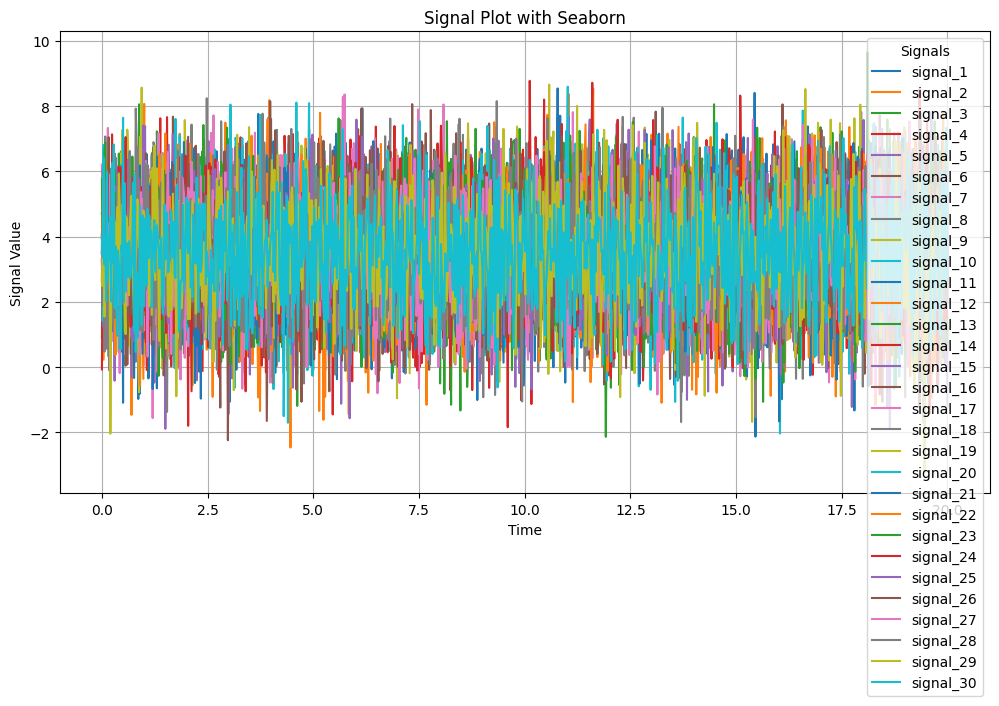

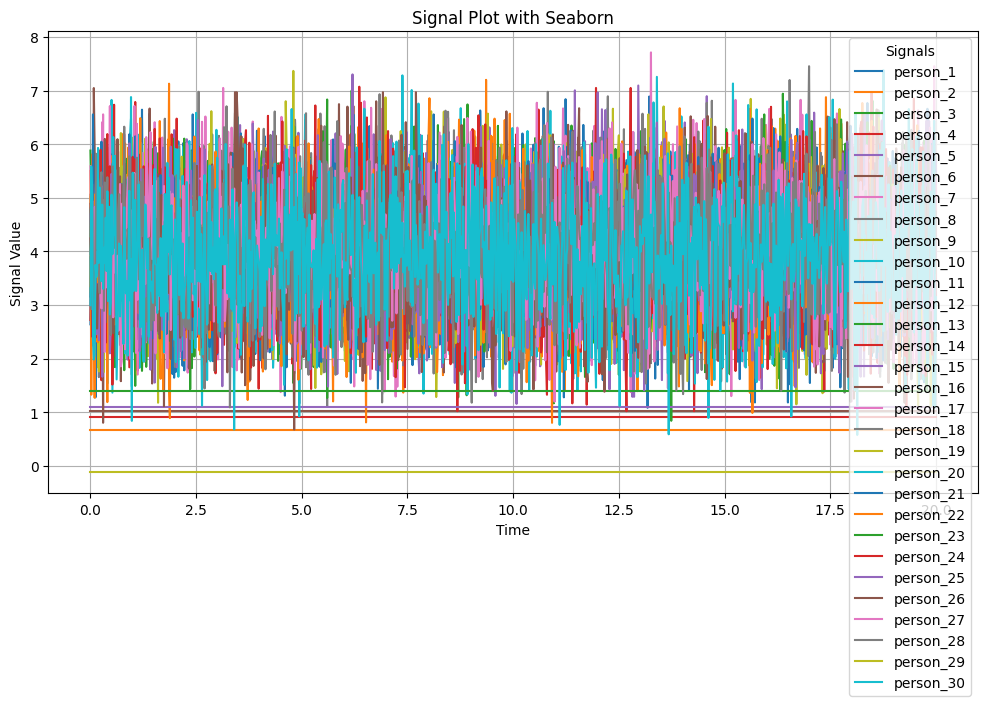

In [20]:
plot_signals(generirani_signali_spovprečjem)
plot_signals(synthetic_data)

In [9]:
# Izračun podobnosti med začetnimi in sintetičnimi podatki generiranimi z uporabo SDV knjižnice
import numpy as np
from sklearn.metrics import mean_squared_error


# Izračun podobnosti z uporabo MSE
mse_values = {}
for column in initial_data.columns[1:]:  # Preskoči stolpec 'time'
    mse = mean_squared_error(initial_data[column], synthetic_data[column])
    mse_values[column] = mse

# Izračun povprečnega MSE čez vse stolpce
average_mse = np.mean(list(mse_values.values()))

# Prikaz rezultatov
#print("MSE za posamezne stolpce:", mse_values)
print("Povprečni MSE:", average_mse)

Povprečni MSE: 3.3848537196253843


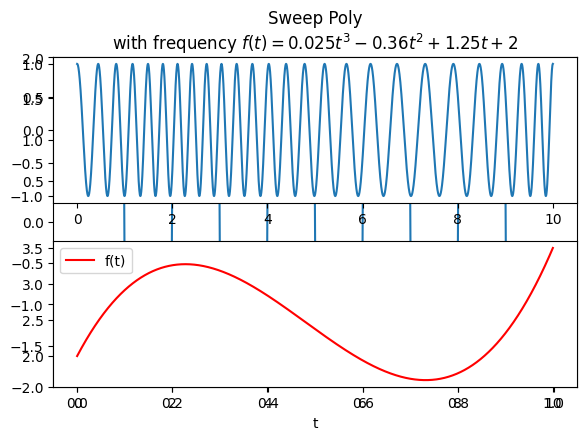

In [10]:
# preizkus možnosti scipy.signal ki je namenjen bolj za obdelavo signalov...
#TODO: odstrani, ker je samo za testiranje generiranja ss scipy
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
t = np.linspace(0, 1, 500, endpoint=False)
plt.plot(t, signal.square(2 * np.pi * 5 * t)) # ostale možnosti sigal.sawtooth, signal.square, signal.sawtooth
plt.ylim(-2, 2)

import numpy as np
from scipy.signal import sweep_poly
p = np.poly1d([0.025, -0.36, 1.25, 2.0])
t = np.linspace(0, 10, 5001)
w = sweep_poly(t, p)

plt.subplot(2, 1, 1)
plt.plot(t, w)
plt.title("Sweep Poly\nwith frequency " +
          "$f(t) = 0.025t^3 - 0.36t^2 + 1.25t + 2$")
plt.subplot(2, 1, 2)
plt.plot(t, p(t), 'r', label='f(t)')
plt.legend()
plt.xlabel('t')
plt.tight_layout()
plt.show()

In [11]:
# Preizkus orodja pyCANON za anonimizacijo podatkov - pyCANON 
# is a Python library which allows the user to know the anonymity level of a dataset 
# based on a set of quasi-identifiers (QI), and a set of sensitive attributes. 

from pycanon import anonymity


data = pd.DataFrame({
    "age": [34, 34, 45, 45, 66, 66],
    "income": [50000, 55000, 60000, 62000, 70000, 75000]
})
# data = pd.concat([data, data], ignore_index=True)
k = anonymity.k_anonymity(data, ["age"])
print(f"k-anonymity: {k}")

alpha, k = anonymity.alpha_k_anonymity(data, ["age"], ["income"])
print(f"alpha k-anonymity: {alpha}, {k}")


data_2 = pd.DataFrame({
    "age": ["30-40", "30-40", "30-40", "60-70", "60-70", "60-70"],
    "income": [50000, 55000, 60000, 65000, 70000, 75000]
})
k = anonymity.k_anonymity(data_2, ["age"])
print(f"k-anonymity: {k}")

alpha, k = anonymity.alpha_k_anonymity(data_2, ["age"], ["income"])
print(f"alpha k-anonymity: {alpha}, {k}")

k-anonymity: 2
alpha k-anonymity: 0.5, 2
k-anonymity: 3
alpha k-anonymity: 0.3333333333333333, 3


In [12]:
# Primer uporabe knjižnice pyCANON za anonimizacijo podatkov
# import pandas as pd
# from pycanon import anonymity, report

# FILE_NAME = "data/adult.csv"
# QI = ["age", "education", "occupation", "relationship", "sex", "native-country"]  # Quasi-identifiers
# SA = ["salary-class"]
# DATA = pd.read_csv(FILE_NAME)
# DATA.columns = DATA.columns.str.strip()


# # Calculate k for k-anonymity:
# k = anonymity.k_anonymity(DATA, QI)

# # Print the anonymity report:
# report.print_report(DATA, QI, SA)

In [13]:
# preizkus uporabe SDV knjižnice za generiranje sintetičnih podatkov in preverjanje anonimnosti
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata


data = pd.DataFrame({
    "age": [34, 34, 45],
    "income": [50000, 55000, 60000]
})


# Nastavitev metapodatkov
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)

# Ročna specifikacija distribucij
model = GaussianCopulaSynthesizer(
    metadata=metadata,
    numerical_distributions={
        "income": "gamma",  # Za pozitivne kontinuirane vrednosti
        "age": "uniform"    # Za diskretne starosti
    },
    default_distribution="gamma"
)
model.fit(data)
synthetic_data = model.sample(num_rows=100)
print(synthetic_data)

synthetic_data["income"] = pd.cut(synthetic_data["income"], bins=[0, 50000, 60000, 100000], labels=["low", "mid", "high"])
# Generalizirajte starost v desetletja
synthetic_data["age_group"] = pd.cut(
    synthetic_data["age"], 
    bins=[30, 40, 50, 60, 70],
    labels=["30-40", "40-50", "50-60", "60-70"]
)

print(synthetic_data)
k = anonymity.k_anonymity(synthetic_data, ["income", "age_group"])
print(f"k-anonymity: {k}")
# Minimalno število enakih kombinacij kvazi-identifikatorjev. k=3 pomeni, da vsaka kombinacija kvazi-ID-jev nastopa vsaj 3-krat


    age  income
0    43   59777
1    42   57590
2    42   59214
3    39   55168
4    36   52574
..  ...     ...
95   43   56006
96   35   50000
97   39   53016
98   40   52268
99   34   50000

[100 rows x 2 columns]
    age income age_group
0    43    mid     40-50
1    42    mid     40-50
2    42    mid     40-50
3    39    mid     30-40
4    36    mid     30-40
..  ...    ...       ...
95   43    mid     40-50
96   35    low     30-40
97   39    mid     30-40
98   40    mid     30-40
99   34    low     30-40

[100 rows x 3 columns]
k-anonymity: 12


c:\Users\Leon\OneDrive - Univerza v Ljubljani\Documents\Fe\MAGISTRSKA\koda\.venv\Lib\site-packages\sdv\single_table\base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\Users\Leon\OneDrive - Univerza v Ljubljani\Documents\Fe\MAGISTRSKA\koda\.venv\Lib\site-packages\sdv\single_table\base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
c:\Users\Leon\OneDrive - Univerza v Ljubljani\Documents\Fe\MAGISTRSKA\koda\.venv\Lib\site-packages\pycanon\anonymity\utils\aux_anonymity.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = data.groupby(by=quasi_ident)


In [14]:
# preizkus anoniomizacije z uporabo anjana knjižnice
# Anjana is a Python library for data anonymization. It provides functions to 
# apply k-anonymity, l-diversity and t-closeness to a dataset.
import pandas as pd
import anjana
from anjana.anonymity import k_anonymity, l_diversity, t_closeness

# Read and process the data
data = pd.read_csv("data/adult.csv") 
data.columns = data.columns.str.strip()
cols = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "sex",
    "native-country",
]
for col in cols:
    data[col] = data[col].str.strip()

# Define the identifiers, quasi-identifiers and the sensitive attribute
quasi_ident = [
    "age",
    "education",
    "marital-status",
    "occupation",
    "sex",
    "native-country",
]
ident = ["race"]
sens_att = "salary-class"

# Select the desired level of k, l and t
k = 10    # Vsaka skupina mora vsebovati ≥10 zapisov
l_div = 2 # Vsaka skupina mora imeti ≥2 različni vrednosti "salary-class"
t = 0.5   # Porazdelitev "salary-class" v skupini se sme največ 50% razlikovati od celotne porazdelitve
supp_level = 50 # Dovoljeno število izbrisanih zapisov

# Import the hierarquies for each quasi-identifier. Define a dictionary containing them
hierarchies = {
    "age": dict(pd.read_csv("data/hierarchies/age.csv", header=None)),
    "education": dict(pd.read_csv("data/hierarchies/education.csv", header=None)),
    "marital-status": dict(pd.read_csv("data/hierarchies/marital.csv", header=None)),
    "occupation": dict(pd.read_csv("data/hierarchies/occupation.csv", header=None)),
    "sex": dict(pd.read_csv("data/hierarchies/sex.csv", header=None)),
    "native-country": dict(pd.read_csv("data/hierarchies/country.csv", header=None)),
}

# Apply the three functions: k-anonymity, l-diversity and t-closeness
data_anon = k_anonymity(data, ident, quasi_ident, k, supp_level, hierarchies)

# Koraki algoritma:
# Supresija identifikatorjev: Stolpec race se odstrani ali zamenja z generičnimi vrednostmi.
# Grupiranje: Zapisom dodeli skupine z enakimi kvazi-ID (npr. vsi 30-40 letniki z doktoratom).
# Generalizacija: Uporabi hierarhije za nadomestitev natančnih vrednosti (npr. "Doctorate" → "Higher Education").
# Preverjanje k-anonimnosti: Izbrise zapise, kjer skupine nimajo vsaj 10 članov.


# data_anon = l_diversity(
#     data_anon, ident, quasi_ident, sens_att, k, l_div, supp_level, hierarchies
# )
# data_anon = t_closeness(
#     data_anon, ident, quasi_ident, sens_att, k, t, supp_level, hierarchies
# )



In [15]:
# Save the anonymized data
# data_anon.to_csv("data/anonymized_data.csv", index=False)

# kaj se zgodi: podatki so anonimizirani na način, da so vrrednosti postavljene v neko kategorijo, ki je definirana v hierarhiji
# npr. bachelor, master, phd so združeni v eno kategorijo education: high_education

In [16]:
# Primer uporabe OpenDP knjižnice za diferencirano zasebnost - ki pomeni, da se podatki anonimizirajo tako, da se ohrani
# statistična zasebnost, vendar se podatki lahko uporabijo za statistične analize
import opendp.prelude as dp
dp.enable_features('contrib')
space = (dp.atom_domain(T=float), dp.absolute_distance(T=float))
laplace_mechanism = space >> dp.m.then_laplace(scale=1.)
dp_value = laplace_mechanism(123.0)
print(dp_value)

122.32959053133936


In [17]:
import opendp.prelude as dp
dp.enable_features("contrib")

# 1. Nastavitve zasebnosti
privacy_unit = dp.unit_of(contributions=1)  # Vsak posameznik prispeva 1 zapis
privacy_loss = dp.loss_of(epsilon=1.)       # Skupni proračun ε=1.0 Manjši ε → večja zasebnost (manj natančni rezultati).Večji ε → manjša zasebnost (natančnejši rezultati).
bounds = (0.0, 100.0)                      # Omejitve za podatke (zmanjša občutljivost)
imputed_value = 50.0                        # Vrednost za zapolnjevanje manjkajočih podatkov

# 2. Generacija testnih podatkov
from random import randint
data = [float(randint(0, 100)) for _ in range(100)]
mean_original = sum(data) / len(data)       # Originalno povprečje (nezaščiteno)

# 3. Inicializacija konteksta z diferencialno zasebnostjo
context = dp.Context.compositor(
    data=data,
    privacy_unit=privacy_unit,
    privacy_loss=privacy_loss,
    split_evenly_over=3  # Razdeli ε=1.0 na 3 poizvedbe (ε=0.33 na poizvedbo). Vsaka poizvedba (npr. štetje, povprečje) ima svojo porabo ε.
)

count_query = (
    context.query()
    .count()                # Izračun števila zapisov (občutljivost Δ=1)
    .laplace()              # Laplaceov šum s scale=Δ/ε=1/0.33≈3.0
)

scale = count_query.param() # scale=3.0 (izračunan iz ε=0.33)
accuracy = dp.discrete_laplacian_scale_to_accuracy(scale=scale, alpha=0.05) # ≈8.0 (95% CI)
dp_count = count_query.release() # Privatizirano število (npr. 105 ±8)
print(f'scale, accuracy, dp_count: {scale}, {accuracy}, {dp_count}')

confidence_interval = (dp_count - accuracy, dp_count + accuracy)
# Privatizirano število (dp_count) = 105 (primer)
# Izračunana natančnost (accuracy) = 8.0
# confidence_interval = (105 - 8.0, 105 + 8.0) = (97, 113)
print(f'confidential interval: {confidence_interval}')


mean_query = (
    context.query()
    .clamp(bounds)          # Omeji vrednosti na [0.0, 100.0] (Δ=100.0)
    .resize(
        size=dp_count,      # Uporabi privatizirano število za prilagoditev velikosti
        constant=imputed_value # Zapolni manjkajoče vrednosti s 50.0
    )
    .mean()                 # Povprečje s sensitivity=Δ/size=100.0/dp_count
    .laplace()              # Šum scale= (100/dp_count)/0.33 ≈ 303.0/dp_count
)

dp_mean = mean_query.release() # Privatizirano povprečje (npr. 52.3 ±3.1)
print(dp_mean)
print(mean_original)

scale, accuracy, dp_count: 3.0000000000000004, 9.445721638273584, 101
confidential interval: (91.55427836172642, 110.44572163827358)
54.57991635594231
51.9


In [18]:
def anonymize_signals(originalni_signali_df, method_code, method_parameters):
    """
    Funkcija za anonimizacijo signalov.

    Args:
        originalni_signali_df (pandas.DataFrame): DataFrame z originalnimi signali (vključuje stolpec 'time').
        method_code (str): Koda metode za anonimizacijo ('quant' za kvantizacijo).
        method_parameters (dict): Parametri metode {'min': 0, 'max': 10, 'dif': 0.2}.

    Returns:
        anonimizirani_signali_df (pandas.DataFrame): DataFrame z anonimiziranimi signali.
    """
    anonimizirani_signali_df = originalni_signali_df.copy()

    # Podvzorčenje
    subsample_rate = method_parameters.get('subsample_rate', 1)
    anonimizirani_signali_df = anonimizirani_signali_df.iloc[::subsample_rate].reset_index(drop=True)

    if method_code == 'quant':
        min_val = method_parameters.get('min', 0)
        max_val = method_parameters.get('max', 10)
        dif = method_parameters.get('dif', 0.2)

        anonimizirani_signali_df.iloc[:, 1:] = np.round((anonimizirani_signali_df.iloc[:, 1:] - min_val) / dif) * dif + min_val
        #kvantizacija signal knjižnica?
        
        # Omeji vrednosti na [min, max]
        anonimizirani_signali_df.iloc[:, 1:] = np.clip(anonimizirani_signali_df.iloc[:, 1:], min_val, max_val)
    
    elif method_code == 'white_noise':
        std = method_parameters.get('std', 0.5)
        for column in anonimizirani_signali_df.columns[1:]:
            anonimizirani_signali_df[column] = anonimizirani_signali_df[column] + np.random.normal(0, std, len(anonimizirani_signali_df))

    return anonimizirani_signali_df


       time  signal_1  signal_2  signal_3  signal_4  signal_5  signal_6  \
0      0.00       4.0       1.5       3.0       3.5       4.0       2.0   
1      0.02       4.0       4.0       4.0       3.5       4.0       3.0   
2      0.04       5.0       4.5       2.5       1.5       4.5       3.5   
3      0.06       4.5       2.5       2.5       3.0       4.5       3.5   
4      0.08       3.5       3.5       5.5       3.5       5.0       2.5   
...     ...       ...       ...       ...       ...       ...       ...   
996   19.92       3.5       4.5       4.5       3.0       3.0       5.0   
997   19.94       1.5       3.0       2.5       4.0       2.5       1.5   
998   19.96       3.0       3.0       4.0       3.5       4.5       3.0   
999   19.98       2.5       3.5       3.5       4.0       2.5       3.5   
1000  20.00       4.5       1.0       3.5       4.5       5.0       3.5   

      signal_7  signal_8  signal_9  ...  signal_11  signal_12  signal_13  \
0          3.5       3.

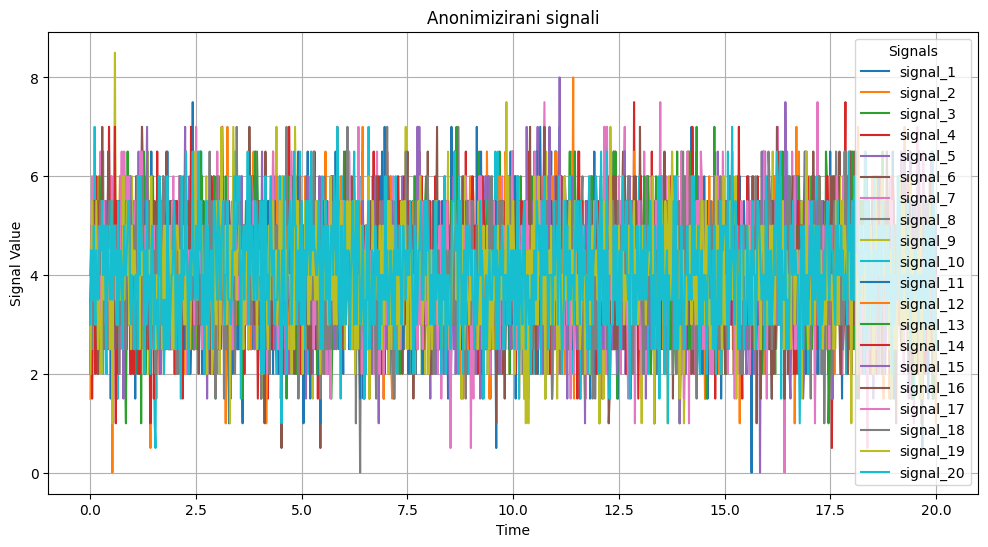

In [19]:
# Anonimizacija podatkov
meth_code = 'quant'
meth_pars = {'min': 0, 'max': 10, 'dif': 0.5}
Y_df = anonymize_signals(signals_with_corr, meth_code, meth_pars)

# Prikaz rezultatov
print(Y_df)
plot_signals(Y_df, 'Anonimizirani signali')

In [20]:
import pandas as pd
import numpy as np

def anonim_count(X_df, Y_df):
    """
    Funkcija za izračun števila anonimiziranih vrednosti.
    TODO:
    Preveri kako knjižnica naredi - npr k-anonimity, l-diversity, t-closeness?

    Args:
        X_df (pandas.DataFrame): DataFrame z originalnimi signali.
        Y_df (pandas.DataFrame): DataFrame z anonimiziranimi signali.

    Returns: 
        pandas.DataFrame: Tabela z signal_ID in številom signalov, ki gredo skozi enake razrede anonimizacije.
    """
    meth_code = 'quant'
    meth_pars = {'min': 0, 'max': 10, 'dif': 1}
    anonimizirani_original = anonymize_signals(X_df, meth_code, meth_pars)

    results = []

    for column in anonimizirani_original.columns[1:]:
        count = 0
        for column2 in Y_df.columns[1:]:
            if (anonimizirani_original[column] == Y_df[column2]).all():
                count += 1 
        results.append({'signal_ID': column, 'count': count})
    
    result_df = pd.DataFrame(results)
    return result_df

In [21]:
# print(signals_with_corr.iloc[:, :3])
# print("\n **** \n")
# print(Y_df.iloc[:, :3])
anonim_count(signals_with_corr, Y_df)

signal_ID  count
0    signal_1      0
1    signal_2      0
2    signal_3      0
3    signal_4      0
4    signal_5      0
5    signal_6      0
6    signal_7      0
7    signal_8      0
8    signal_9      0
9   signal_10      0
10  signal_11      0
11  signal_12      0
12  signal_13      0
13  signal_14      0
14  signal_15      0
15  signal_16      0
16  signal_17      0
17  signal_18      0
18  signal_19      0
19  signal_20      0

In [22]:
k_anon = anonymity.k_anonymity(Y_df, quasi_ident=list(Y_df.columns[1:]))
print(f"k-anonymity: {k_anon}")

k-anonymity: 1


In [23]:
import pandas as pd
from pycanon import anonymity

def calculate_k_values(original_df, anonymized_df):
    """Izračun k-anonimnosti za vsak signal posebej."""
    results = []
    
    for signal in original_df.columns[:]:
        # K-anonimnost za originalne podatke
        k_orig = anonymity.k_anonymity(original_df, quasi_ident=["signal_1", "signal_2", "signal_3", "signal_4"]) 
        
        # K-anonimnost za anonimizirane podatke
        k_anon = anonymity.k_anonymity(anonymized_df, quasi_ident=["signal_1", "signal_2", "signal_3", "signal_4"])
        #TODO: narobe ker Kombinacije signalov: Funkcija ne preverja k-anonimnosti kombinacij signalov (npr. signal_1 + signal_2).

        results.append({
            "Signal": signal,
            "k_original": k_orig,
            "k_anonymized": k_anon
        })
    
    return pd.DataFrame(results)


In [24]:
# Originalni podatki
original_data = pd.DataFrame({
    "signal_1": [0.34, 0.45, 0.66, 0.34, 0.45],
    "signal_2": [0.21, 0.39, 0.55, 0.21, 0.39],
    "signal_3": [0.1, 0.2, 0.3, 0.1, 0.2],
    "signal_4": [0.5, 0.5, 0.5, 0.5, 0.5]
})

# Anonimizirani podatki (kvantizacija na 0.5)
anonymized_data = pd.DataFrame({
    "signal_1": [0.5, 0.5, 0.5, 0.5, 0.5],
    "signal_2": [0.0, 0.5, 0.5, 0.0, 0.5],
    "signal_3": [0.0, 0.5, 0.5, 0.0, 0.5],
    "signal_4": [0.5, 0.5, 0.5, 0.5, 0.7]
})

# Klic funkcije
# k_table = calculate_k_values(signals_with_corr, Y_df)
# print(k_table)

k_table = calculate_k_values(original_data, anonymized_data)
print(k_table)



     Signal  k_original  k_anonymized
0  signal_1           1             1
1  signal_2           1             1
2  signal_3           1             1
3  signal_4           1             1


In [25]:
import pandas as pd
from pycanon import anonymity
from itertools import combinations

def calculate_k_values(original_df, anonymized_df, check_combinations=True):
    """Izračun k-anonimnosti za posamezne signale in njihove kombinacije."""
    results = []
    signal_columns = [col for col in original_df.columns if col not in ['time_interval']]
    
    # 1. Analiza posameznih signalov
    for signal in signal_columns:
        k_orig = anonymity.k_anonymity(original_df, quasi_ident=[signal])
        k_anon = anonymity.k_anonymity(anonymized_df, quasi_ident=[signal])
        results.append({
            "Signali": signal,
            "k_original": k_orig,
            "k_anonymized": k_anon
        })
    
    # 2. Analiza kombinacij signalov (če je aktivirano)
    if check_combinations:
        for r in range(2, len(signal_columns)+1):
            for combo in combinations(signal_columns, r):
                combo_name = " + ".join(combo)
                k_orig = anonymity.k_anonymity(original_df, quasi_ident=list(combo))
                k_anon = anonymity.k_anonymity(anonymized_df, quasi_ident=list(combo))
                results.append({
                    "Signali": combo_name,
                    "k_original": k_orig,
                    "k_anonymized": k_anon
                })
    
    return pd.DataFrame(results)


In [26]:
# Originalni podatki
original_data = pd.DataFrame({
    "signal_1": [0.34, 0.45, 0.66, 0.34, 0.45],
    "signal_2": [0.21, 0.39, 0.55, 0.21, 0.39]
})

# Anonimizirani podatki (kvantizacija na 0.5)
anonymized_data = pd.DataFrame({
    "signal_1": [0.5, 0.5, 0.5, 0.5, 0.0],
    "signal_2": [0.0, 0.5, 0.5, 0.0, 0.5]
})

# Klic funkcije z analizo kombinacij
# k_table = calculate_k_values(signals_with_corr.iloc[:, 1:6], Y_df.iloc[:, 1:6], check_combinations=True)
# print(k_table)

k_table = calculate_k_values(original_data, anonymized_data)
print(k_table)

               Signali  k_original  k_anonymized
0             signal_1           1             1
1             signal_2           1             2
2  signal_1 + signal_2           1             1


In [27]:
import pandas as pd
from pycanon import anonymity

# Primer podatkov
data = pd.DataFrame({
    "age": [34, 45, 34, 45],
    "zip": [1000, 2000, 1000, 2000],
    "diagnosis": ["Diabetes", "Asthma", "Heart Disease", "Diabetes"]
})
print(data)
# 1. Generalizacija starosti in poštnih številk
data["age"] = data["age"].apply(lambda x: f"{(x//10)*10}-{(x//10)*10 + 10}")
data["zip"] = data["zip"].apply(lambda x: f"{x//1000 * 1000}-{(x//1000 + 1)*1000}")

print(data)

# 2. Preverjanje k-anonimnosti
quasi_identifiers = ["age", "zip"]
k = anonymity.k_anonymity(data, quasi_identifiers)
print(f"k = {k}")  # Izhod: k = 2

   age   zip      diagnosis
0   34  1000       Diabetes
1   45  2000         Asthma
2   34  1000  Heart Disease
3   45  2000       Diabetes
     age        zip      diagnosis
0  30-40  1000-2000       Diabetes
1  40-50  2000-3000         Asthma
2  30-40  1000-2000  Heart Disease
3  40-50  2000-3000       Diabetes
k = 2


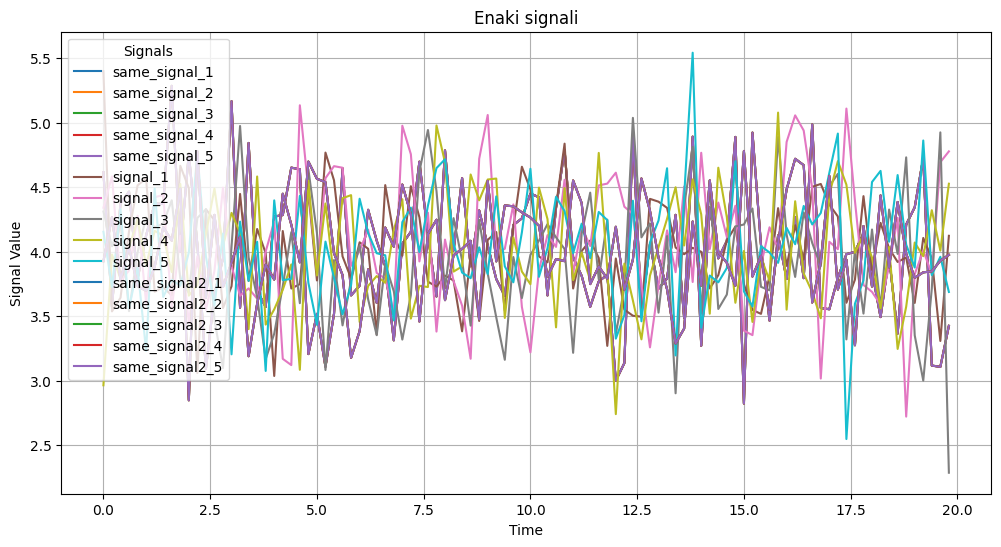

(100, 16)


c:\Users\Leon\OneDrive - Univerza v Ljubljani\Documents\Fe\MAGISTRSKA\koda\.venv\Lib\site-packages\sdv\single_table\base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\Users\Leon\OneDrive - Univerza v Ljubljani\Documents\Fe\MAGISTRSKA\koda\.venv\Lib\site-packages\sdv\single_table\base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


(100, 16)


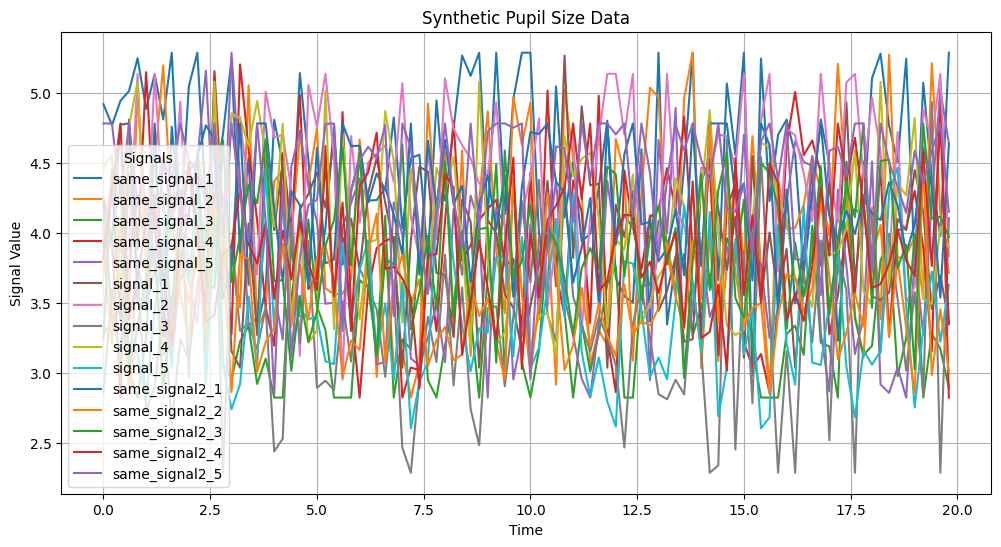

In [28]:
# Generiranje enakih signalov, za testiranje
def generate_same_signals(time, mu, std, ac, N):
    """
    Funkcija generira N enakih naključnih signalov glede na podane parametre.

    Args:
        time (numpy array): Časovni intervali (npr. np.arange(0, 20, 0.02)).
        mu (float): Povprečje za generiranje naključnih vrednosti.
        std (float): Standardni odklon za generiranje naključnih vrednosti.
        ac (float): Korelacija med signali (trenutno ne uporabljeno).
        N (int): Število signalov.

    Returns:
        pandas.DataFrame: DataFrame s časovnimi intervali in generiranimi signali.
    """
    # Generiraj en naključni signal iz normalne porazdelitve
    single_signal = np.random.normal(mu, std, size=len(time))
    
    # Ustvari matriko z N kopijami tega signala
    data = np.tile(single_signal, (N, 1)).T
    
    # Pretvori v DataFrame in dodaj časovni stolpec
    sameSignals_df = pd.DataFrame(data, columns=[f"same_signal_{i+1}" for i in range(N)])
    sameSignals_df.insert(0, "time", time)  # Dodaj stolpec 'time' na prvo mesto
    
    return sameSignals_df

def generate_same_signals2(time, mu, std, ac, N):
    """
    Funkcija generira N enakih naključnih signalov glede na podane parametre.

    Args:
        time (numpy array): Časovni intervali (npr. np.arange(0, 20, 0.02)).
        mu (float): Povprečje za generiranje naključnih vrednosti.
        std (float): Standardni odklon za generiranje naključnih vrednosti.
        ac (float): Korelacija med signali (trenutno ne uporabljeno).
        N (int): Število signalov.

    Returns:
        pandas.DataFrame: DataFrame s časovnimi intervali in generiranimi signali.
    """
    # Generiraj en naključni signal iz normalne porazdelitve
    single_signal = np.random.normal(mu, std, size=len(time))
    
    # Ustvari matriko z N kopijami tega signala
    data = np.tile(single_signal, (N, 1)).T
    
    # Pretvori v DataFrame in dodaj časovni stolpec
    sameSignals_df = pd.DataFrame(data, columns=[f"same_signal2_{i+1}" for i in range(N)])
    sameSignals_df.insert(0, "time", time)  # Dodaj stolpec 'time' na prvo mesto
    
    return sameSignals_df

time = np.arange(0, 20.00, 0.2)  # Časovni intervali od 0 do 20 s korakom 0.02
mu = 4                            # Povprečje
std = 0.5                           # Standardni odklon
ac = 0                            # Korelacija (trenutno ni uporabljena)
N = 5                           # Število signalov

same_signals_df = generate_same_signals(time, mu, std, ac, N)
same_signals_df_2 = generate_same_signals2(time, 4, 0.4, ac, N)
random_signal_df = generate_rand_signals(time, mu, std, N)

zdruzeni_signali = pd.concat([same_signals_df, random_signal_df.iloc[:, 1:], same_signals_df_2.iloc[:,1:]], axis=1)

#plot_signals(random_signal_df)

plot_signals(zdruzeni_signali, 'Enaki signali')
print(zdruzeni_signali.shape)
signali_s_sumom = anonymize_signals(zdruzeni_signali, 'white_noise', {'std': 0.5})

#generj sintetične signale sdv knjižnica
# Generiranje podatkov s pomočjo SDV knjižnice, ki potrebuje metapodatke oz. realne podatke an katerih se "nauči" lastnosti
# Ustvarite metapodatke za vaše podatke
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=zdruzeni_signali.iloc[:, 1:])

# Inicializirajte in naučite sintetizator
#synthesizer = GaussianCopulaSynthesizer(metadata)

# from sdv.single_table import CopulaGANSynthesizer
# synthesizer = CopulaGANSynthesizer(
#     metadata,
#     epochs=500,  # Večja natančnost
#     #numerical_distributions={'signal1': 'gaussian_kde'},
#     cuda=True  # Pospeši z GPU
# )
from sdv.single_table import CTGANSynthesizer
synthesizer = CTGANSynthesizer(metadata, batch_size=1000)

synthesizer.fit(zdruzeni_signali.iloc[:, 1:])

# Generirajte sintetične podatke
num_synthetic_rows = len(zdruzeni_signali)  # Ustvarite enako število vrstic kot v originalnih podatkih
synthetic_data = synthesizer.sample(num_rows=num_synthetic_rows)
synthetic_data.insert(0, "time", np.arange(0, 20.0, 0.2))  # Dodaj časovni stolpec

print(synthetic_data.shape)

plot_signals(synthetic_data, title="Synthetic Pupil Size Data")


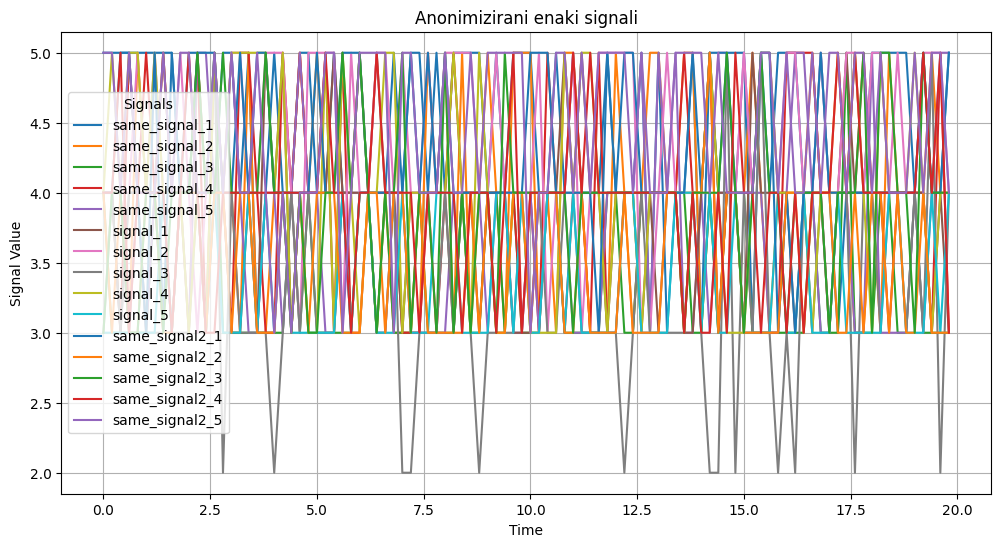

         signal_ID  count
0    same_signal_1      1
1    same_signal_2      1
2    same_signal_3      1
3    same_signal_4      1
4    same_signal_5      1
5         signal_1      1
6         signal_2      1
7         signal_3      1
8         signal_4      1
9         signal_5      1
10  same_signal2_1      1
11  same_signal2_2      1
12  same_signal2_3      1
13  same_signal2_4      1
14  same_signal2_5      1


In [29]:
anonimizirani_enaki_siglani = anonymize_signals(synthetic_data, 'quant', {'min': 0, 'max': 10, 'dif': 1})

plot_signals(anonimizirani_enaki_siglani, 'Anonimizirani enaki signali')
print(anonim_count(synthetic_data, anonimizirani_enaki_siglani))

In [30]:
from sdv.metadata import SingleTableMetadata
# from sdv.single_table import NumericalRange

# metadata = SingleTableMetadata()
# metadata.detect_from_dataframe(zdruzeni_signali)
# metadata.update_column(
#     column_name='pupil_size',
#     sdtype='numerical',
#     distribution='truncated_normal',
#     distribution_parameters={
#         'mean': 3.5,
#         'std': 0.6,
#         'lower_bound': 2.0,
#         'upper_bound': 5.0
#     }
# )

time = np.arange(0, 20.00, 0.2)  # Časovni intervali od 0 do 20 s korakom 0.02
mu = 4                            # Povprečje
std = 0.5                           # Standardni odklon
ac = 0                            # Korelacija (trenutno ni uporabljena)
N = 5  
random_signal_df = generate_rand_signals(time, mu, std, N)

print(random_signal_df)

df=random_signal_df

# Posodobitev za vsak signal posebej
person_columns = [f'signal_{i}' for i in range(1, 6)]
for col in person_columns:
    metadata.update_column(
        column_name=col,
        sdtype='numerical',
        computer_representation='Float'
    )
    
    # Ročno dodajanje omejitev prek distribucijskih parametrov
    metadata.update_column(
        column_name=col,
        sdtype='numerical',
        # distribution_parameters={
        #     'min': random_signal_df[col].min(),
        #     'max': random_signal_df[col].max(),
        #     'mean': random_signal_df[col].mean(),
        #     'std': random_signal_df[col].std()
        # }
    )
# # Inicializirajte in naučite sintetizator
# synthesizer = GaussianCopulaSynthesizer(metadata)

# synthesizer.fit(random_signal_df)

# # Generirajte sintetične podatke
# num_synthetic_rows = len(random_signal_df)  # Ustvarite enako število vrstic kot v originalnih podatkih
# synthetic_data = synthesizer.sample(num_rows=num_synthetic_rows)
# #synthetic_data.insert(0, "time", np.arange(0, 20.0, 0.2))  # Dodaj časovni stolpec

# print(synthetic_data.shape)



    time  signal_1  signal_2  signal_3  signal_4  signal_5
0    0.0  3.288570  2.991408  4.642571  4.314081  4.095304
1    0.2  4.853453  3.797734  4.386901  3.583264  5.256096
2    0.4  3.360748  3.558837  3.886736  3.188554  4.150136
3    0.6  3.459199  4.318789  3.413520  3.250541  3.950518
4    0.8  4.596577  4.049880  4.853189  4.055557  3.690486
..   ...       ...       ...       ...       ...       ...
95  19.0  3.477827  3.403098  3.070378  4.474191  4.257577
96  19.2  3.896422  4.152791  3.434541  3.467817  4.019606
97  19.4  3.763306  4.294355  3.848694  4.181440  3.385314
98  19.6  3.645808  3.559993  3.992549  5.062914  5.029850
99  19.8  4.056102  3.945038  4.711677  3.584230  3.820571

[100 rows x 6 columns]


## Pri generiranju sintetičnih podatkov delaj brez časovne osi... bo bolje....

                           time  signal_1  signal_2  signal_3  signal_4  \
0 2025-03-13 13:34:00.022224030  3.787464  6.676305  5.460317  6.851503   
1 2025-03-13 13:34:00.064854588  5.032011  3.867900  4.862869  4.052056   
2 2025-03-13 13:34:00.068842438  6.614375  3.591190  3.884481  5.882622   
3 2025-03-13 13:34:00.112948381  4.214616  4.832200  5.261243  4.963907   
4 2025-03-13 13:34:00.162334102  6.535525  4.357139  5.421255  7.121092   

   signal_5  signal_6  signal_7  signal_8  signal_9  ...  signal_31  \
0  6.361270  3.972064  5.902939  6.914560  3.425421  ...   4.138672   
1  5.257974  5.365052  7.528067  7.204759  4.289061  ...   4.861341   
2  5.291517  5.307802  5.992645  3.725284  5.377084  ...   4.120357   
3  7.525079  5.812469  6.220307  5.752475  6.343780  ...   6.587661   
4  5.041976  5.726855  3.723912  5.411328  4.880591  ...   5.720341   

   signal_32  signal_33  signal_34  signal_35  signal_36  signal_37  \
0   3.547929   5.783721   3.384524   5.326685   4.3

c:\Users\Leon\OneDrive - Univerza v Ljubljani\Documents\Fe\MAGISTRSKA\koda\.venv\Lib\site-packages\sdv\single_table\base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)


                        time    signal_1  signal_2
0 2025-03-13 13:34:05.384524  16566492.0  6.583598
1 2025-03-13 13:34:06.386249   9042386.0  5.683948
2 2025-03-13 13:34:05.207319  11889510.0  6.435456
3 2025-03-13 13:34:03.421595   9301443.0  5.357543
4 2025-03-13 13:34:02.012550   6832665.0  4.733943


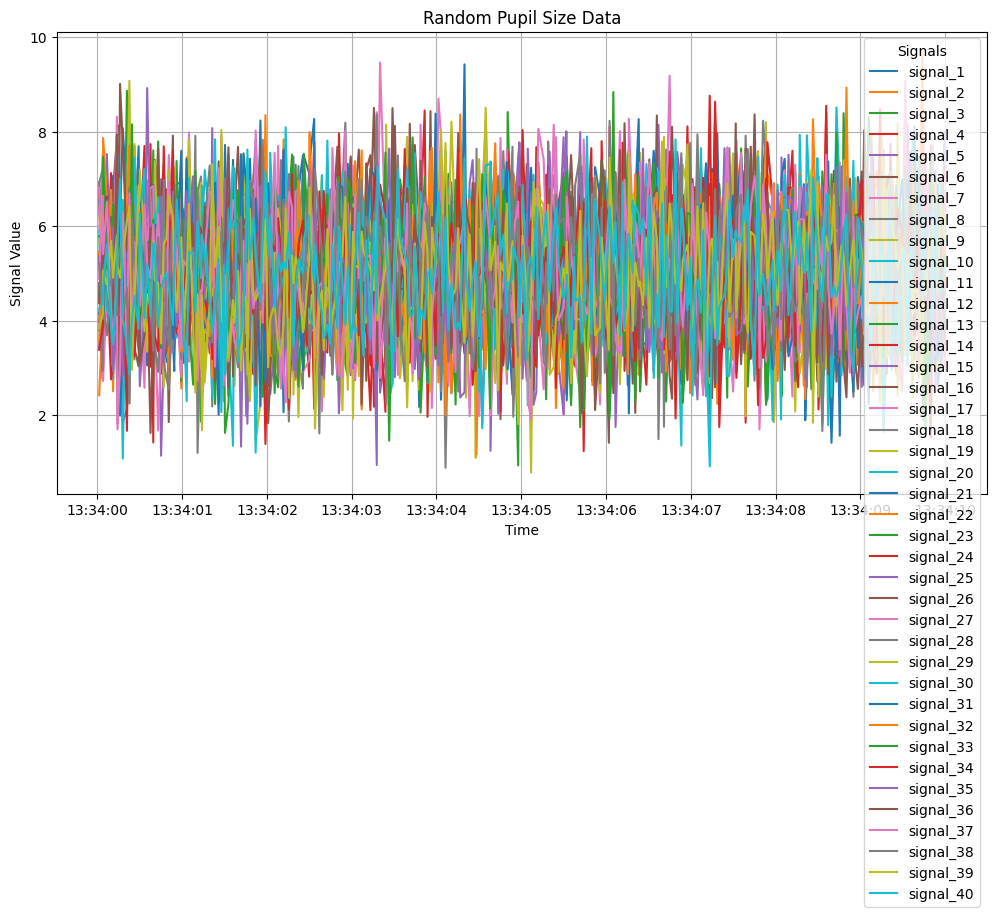

(300, 2)


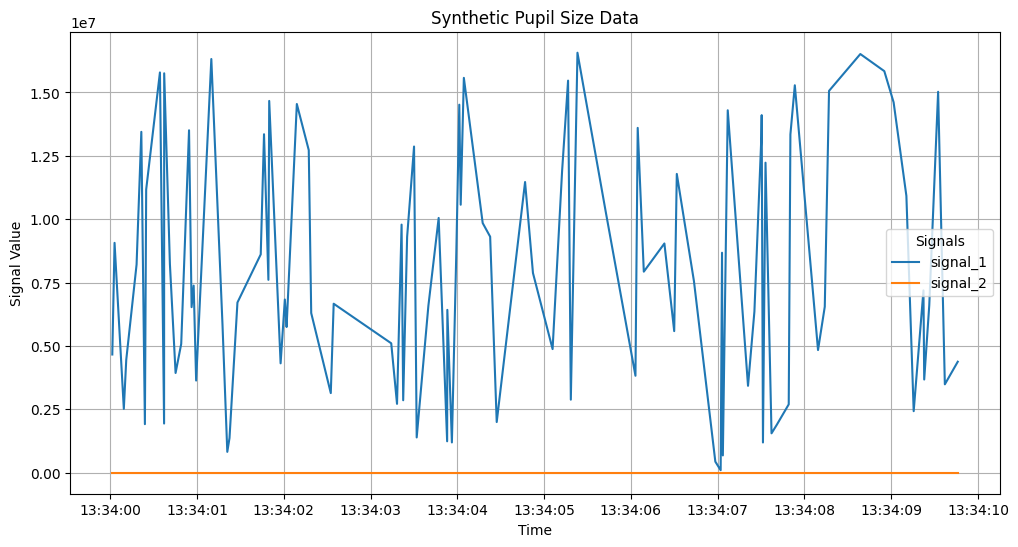

(100, 3)


In [31]:
start = datetime(2025, 3, 13, 13, 34)
random_signali_datetime = generate_rand_signals_datetime(
    start_time=start,
    duration=10,
    sampling_rate=30,
    mu=5.0,
    std=1.2,
    N=40
)

print(random_signali_datetime.head())

from sdv.metadata import Metadata

# metadata = Metadata.detect_from_dataframe(
#     data=random_signali_datetime.iloc[:,:3],
#     table_name='meritve_zenice')

# python_dict = metadata.to_dict()
# print(python_dict)

# metadata = SingleTableMetadata()
# metadata.add_column(
#                    column_name='time',
#                     sdtype='datetime')
# metadata.add_column(
#                    column_name='signal_1',
#                    sdtype='numerical')
metadata_dict = {
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "sequence_key": "signal_1",
    "sequence_index": "time",
    "columns": {
        "time": { "sdtype": "datetime", "datetime_format": "%Y-%m-%dT%H:%M:%S.%f" },
        "signal_1": { "sdtype": "id"},
        "signal_2": { "sdtype": "numerical" },

    }
}

metadata = SingleTableMetadata.load_from_dict(metadata_dict)

metadata.validate()

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(random_signali_datetime.iloc[:,:3])
synthetic_data = synthesizer.sample(num_rows=100)

# from sdv.single_table import GaussianCopulaSynthesizer

# from sdv.sequential import PARSynthesizer

# # Step 1: Create the synthesizer
# synthesizer = GaussianCopulaSynthesizer(metadata)

# # Step 2: Train the synthesizer
# synthesizer.fit(random_signali_datetime.iloc[:,1:3])

# # Step 3: Generate synthetic data
# synthetic_data = synthesizer.sample(100)

print(synthetic_data.head())
# synthetic_data.insert(0, "time", np.arange(0, 20.00, 0.2)  # Časovni intervali od 0 do 20 s korakom 0.02
# )  # Dodaj stolpec 'time' na prvo mesto


plot_signals(random_signali_datetime, title='Random Pupil Size Data')
print(random_signali_datetime.iloc[:,1:3].shape)
plot_signals(synthetic_data, title="Synthetic Pupil Size Data")
print(synthetic_data.shape)



                           time  signal_1  signal_2  signal_3  signal_4  \
0 2025-03-13 13:34:00.031510235  5.128595  6.246359  3.944944  4.629195   
1 2025-03-13 13:34:00.050750000  4.856429  4.871096  4.561894  4.742702   
2 2025-03-13 13:34:00.089089196  2.535821  6.878808  4.768885  5.957035   
3 2025-03-13 13:34:00.101936657  4.149074  5.352943  6.895345  5.940219   
4 2025-03-13 13:34:00.164840556  5.603706  6.277859  2.470666  4.368402   

   signal_5  signal_6  signal_7  signal_8  signal_9  ...  signal_31  \
0  4.847947  7.044755  5.817535  5.433687  7.276237  ...   7.171434   
1  3.241224  5.492248  4.447223  4.906770  5.509788  ...   5.438444   
2  3.757426  5.159306  4.773490  5.047573  4.942530  ...   4.942740   
3  3.962852  5.007736  6.304333  4.963998  4.796325  ...   2.903555   
4  2.162443  3.685518  7.323426  2.805615  4.161122  ...   2.473128   

   signal_32  signal_33  signal_34  signal_35  signal_36  signal_37  \
0   3.191038   4.565624   5.703845   4.346062   7.9

c:\Users\Leon\OneDrive - Univerza v Ljubljani\Documents\Fe\MAGISTRSKA\koda\.venv\Lib\site-packages\sdv\single_table\base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


   signal_1  signal_2
0  3.700614  1.757131
1  4.147754  1.757131
2  3.857178  1.757131
3  5.074588  1.757131
4  5.925466  1.757131


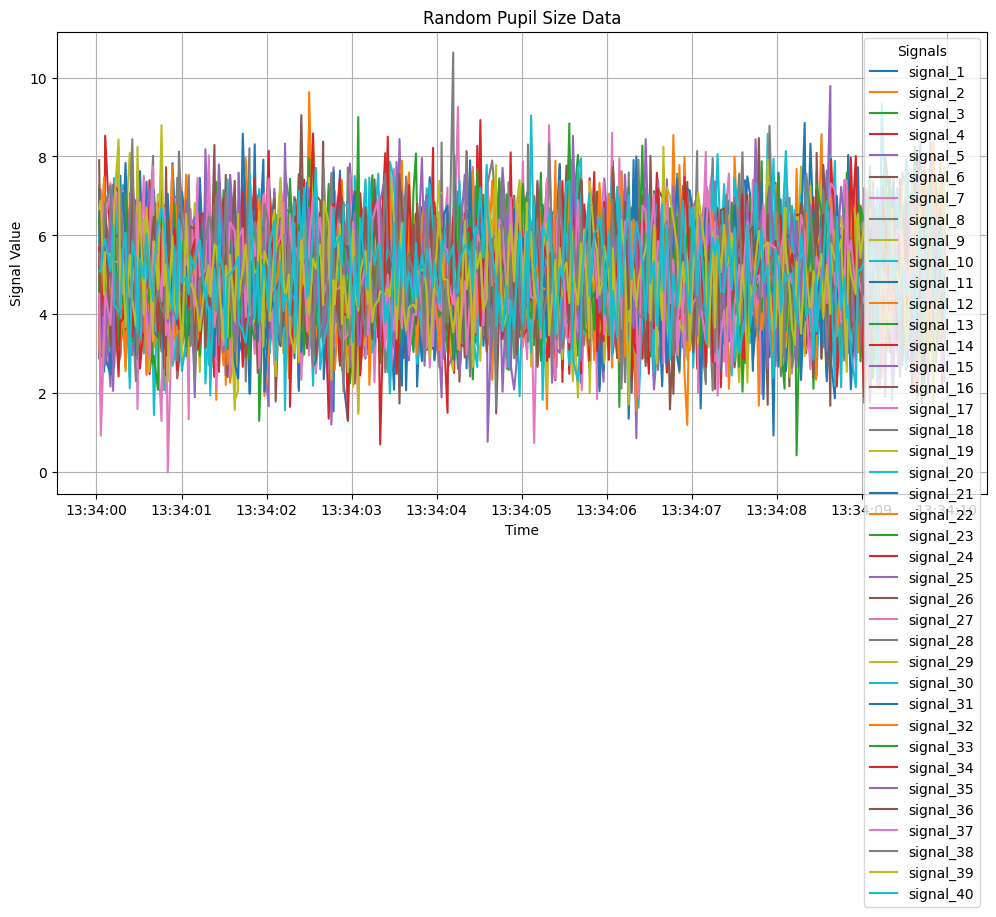

(300, 2)


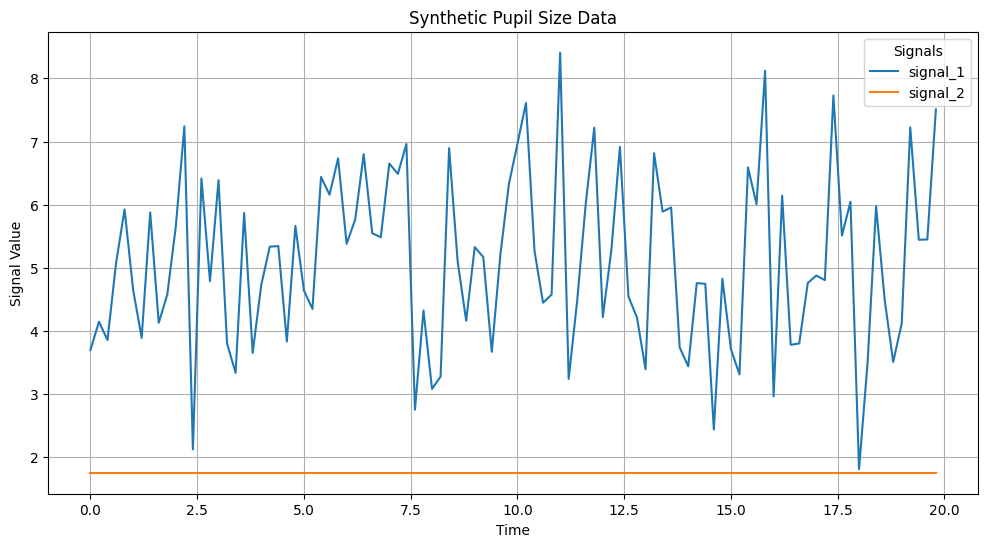

(100, 3)


In [32]:
start = datetime(2025, 3, 13, 13, 34)
random_signali_datetime = generate_rand_signals_datetime(
    start_time=start,
    duration=10,
    sampling_rate=30,
    mu=5.0,
    std=1.2,
    N=40
)

print(random_signali_datetime.head())

from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(
    data=random_signali_datetime.iloc[:,1:3],
    table_name='meritve_zenice')

python_dict = metadata.to_dict()
print(python_dict)
metadata.validate()

from sdv.single_table import GaussianCopulaSynthesizer

from sdv.sequential import PARSynthesizer

# Step 1: Create the synthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)

# Step 2: Train the synthesizer
synthesizer.fit(random_signali_datetime.iloc[:,1:3])

# Step 3: Generate synthetic data
synthetic_data = synthesizer.sample(100)

print(synthetic_data.head())
synthetic_data.insert(0, "time", np.arange(0, 20.00, 0.2)  # Časovni intervali od 0 do 20 s korakom 0.02
)  # Dodaj stolpec 'time' na prvo mesto


plot_signals(random_signali_datetime, title='Random Pupil Size Data')
print(random_signali_datetime.iloc[:,1:3].shape)
plot_signals(synthetic_data, title="Synthetic Pupil Size Data")
print(synthetic_data.shape)


In [33]:
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(
    data=random_signal_df.iloc[:,:3],
    table_name='meritve_zenice')

python_dict = metadata.to_dict()
print(python_dict)
metadata.set_sequence_key(column_name='time')

metadata.validate()

# from sdv.single_table import GaussianCopulaSynthesizer

# # Step 1: Create the synthesizer
# synthesizer = GaussianCopulaSynthesizer(metadata)

# # Step 2: Train the synthesizer
# synthesizer.fit(random_signal_df.iloc[:,1:3])

# # Step 3: Generate synthetic data
# synthetic_data = synthesizer.sample(num_rows=100)

# #dodaj time stolpec
# synthetic_data.insert(0, "time", np.arange(0, 20.0, 0.2))  # Dodaj časovni stolpec
# print(synthetic_data)

# plot_signals(synthetic_data, 'Random signali')

{'tables': {'meritve_zenice': {'columns': {'time': {'sdtype': 'numerical'}, 'signal_1': {'sdtype': 'numerical'}, 'signal_2': {'sdtype': 'numerical'}}}}, 'relationships': [], 'METADATA_SPEC_VERSION': 'V1'}


InvalidMetadataError: The sequence_keys ['time'] must be type 'id' or another PII type.

In [ ]:
df_transposed = random_signal_df.set_index('time').transpose()
#print(df_transposed)

from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(
    data=df_transposed,
    table_name='meritve_zenice_2')


python_dict = metadata.to_dict()
print(python_dict)

# from sdv.single_table import GaussianCopulaSynthesizer

# Step 1: Create the synthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)

# Step 2: Train the synthesizer
synthesizer.fit(df_transposed)

# # Step 3: Generate synthetic data
# synthetic_data = synthesizer.sample(num_rows=100)



# df_original = df_transposed.transpose().reset_index().rename(columns={'index': 'time'})
# plot_signals(df_original, 'Random signali')

{'tables': {'meritve_zenice_2': {'columns': {'0.0': {'sdtype': 'numerical'}, '0.2': {'sdtype': 'numerical'}, '0.4': {'sdtype': 'numerical'}, '0.6000000000000001': {'sdtype': 'numerical'}, '0.8': {'sdtype': 'numerical'}, '1.0': {'sdtype': 'numerical'}, '1.2000000000000002': {'sdtype': 'numerical'}, '1.4000000000000001': {'sdtype': 'numerical'}, '1.6': {'sdtype': 'numerical'}, '1.8': {'sdtype': 'numerical'}, '2.0': {'sdtype': 'numerical'}, '2.2': {'sdtype': 'numerical'}, '2.4000000000000004': {'sdtype': 'numerical'}, '2.6': {'sdtype': 'numerical'}, '2.8000000000000003': {'sdtype': 'numerical'}, '3.0': {'sdtype': 'numerical'}, '3.2': {'sdtype': 'numerical'}, '3.4000000000000004': {'sdtype': 'numerical'}, '3.6': {'sdtype': 'numerical'}, '3.8000000000000003': {'sdtype': 'numerical'}, '4.0': {'sdtype': 'numerical'}, '4.2': {'sdtype': 'numerical'}, '4.4': {'sdtype': 'numerical'}, '4.6000000000000005': {'sdtype': 'numerical'}, '4.800000000000001': {'sdtype': 'numerical'}, '5.0': {'sdtype': 'nu

c:\Users\Leon\OneDrive - Univerza v Ljubljani\Documents\Fe\MAGISTRSKA\koda\.venv\Lib\site-packages\sdv\single_table\base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


InvalidDataError: The provided data does not match the metadata:
The columns [0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2000000000000002, 1.4000000000000001, 1.6, 1.8, 2.0, 2.2, 2.4000000000000004, 2.6, 2.8000000000000003, 3.0, 3.2, 3.4000000000000004, 3.6, 3.8000000000000003, 4.0, 4.2, 4.4, 4.6000000000000005, 4.800000000000001, 5.0, 5.2, 5.4, 5.6000000000000005, 5.800000000000001, 6.0, 6.2, 6.4, 6.6000000000000005, 6.800000000000001, 7.0, 7.2, 7.4, 7.6000000000000005, 7.800000000000001, 8.0, 8.200000000000001, 8.4, 8.6, 8.8, 9.0, 9.200000000000001, 9.4, 9.600000000000001, 9.8, 10.0, 10.200000000000001, 10.4, 10.600000000000001, 10.8, 11.0, 11.200000000000001, 11.4, 11.600000000000001, 11.8, 12.0, 12.200000000000001, 12.4, 12.600000000000001, 12.8, 13.0, 13.200000000000001, 13.4, 13.600000000000001, 13.8, 14.0, 14.200000000000001, 14.4, 14.600000000000001, 14.8, 15.0, 15.200000000000001, 15.4, 15.600000000000001, 15.8, 16.0, 16.2, 16.400000000000002, 16.6, 16.8, 17.0, 17.2, 17.400000000000002, 17.6, 17.8, 18.0, 18.2, 18.400000000000002, 18.6, 18.8, 19.0, 19.200000000000003, 19.400000000000002, 19.6, 19.8] are not present in the metadata.

The metadata columns ['0.0', '0.2', '0.4', '0.6000000000000001', '0.8', '1.0', '1.2000000000000002', '1.4000000000000001', '1.6', '1.8', '10.0', '10.200000000000001', '10.4', '10.600000000000001', '10.8', '11.0', '11.200000000000001', '11.4', '11.600000000000001', '11.8', '12.0', '12.200000000000001', '12.4', '12.600000000000001', '12.8', '13.0', '13.200000000000001', '13.4', '13.600000000000001', '13.8', '14.0', '14.200000000000001', '14.4', '14.600000000000001', '14.8', '15.0', '15.200000000000001', '15.4', '15.600000000000001', '15.8', '16.0', '16.2', '16.400000000000002', '16.6', '16.8', '17.0', '17.2', '17.400000000000002', '17.6', '17.8', '18.0', '18.2', '18.400000000000002', '18.6', '18.8', '19.0', '19.200000000000003', '19.400000000000002', '19.6', '19.8', '2.0', '2.2', '2.4000000000000004', '2.6', '2.8000000000000003', '3.0', '3.2', '3.4000000000000004', '3.6', '3.8000000000000003', '4.0', '4.2', '4.4', '4.6000000000000005', '4.800000000000001', '5.0', '5.2', '5.4', '5.6000000000000005', '5.800000000000001', '6.0', '6.2', '6.4', '6.6000000000000005', '6.800000000000001', '7.0', '7.2', '7.4', '7.6000000000000005', '7.800000000000001', '8.0', '8.200000000000001', '8.4', '8.6', '8.8', '9.0', '9.200000000000001', '9.4', '9.600000000000001', '9.8'] are not present in the data.

In [ ]:
from scipy.stats import pearson3
import numpy as np

def generate_pupil_signal(num_samples, target_mean, target_std, target_skew):
    # Prilagodi parametre Pearsonove distribucije
    skew_param = target_skew
    loc = target_mean - target_std * skew_param / np.sqrt(1 + skew_param**2)
    scale = target_std / np.sqrt(1 + skew_param**2)
    
    # Generiraj vzorce
    return pearson3.rvs(skew_param, loc=loc, scale=scale, size=num_samples)


In [ ]:
synthetic_data = pd.DataFrame()
for signal, stats in zdruzeni_signali.items():
    signal = generate_pupil_signal(
        num_samples=1000,
        target_mean=stats['mean'],
        target_std=stats['std'],
        target_skew=stats['skew']
    )
    synthetic_data[signal] = signal

KeyError: 'mean'